
# Tinting gray-scale images

It can be useful to artificially tint an image with some color, either to
highlight particular regions of an image or maybe just to liven up a grayscale
image. This example demonstrates image-tinting by scaling RGB values and by
adjusting colors in the HSV color-space.

In 2D, color images are often represented in RGB---3 layers of 2D arrays, where
the 3 layers represent (R)ed, (G)reen and (B)lue channels of the image. The
simplest way of getting a tinted image is to set each RGB channel to the
grayscale image scaled by a different multiplier for each channel. For example,
multiplying the green and blue channels by 0 leaves only the red channel and
produces a bright red image. Similarly, zeroing-out the blue channel leaves
only the red and green channels, which combine to form yellow.


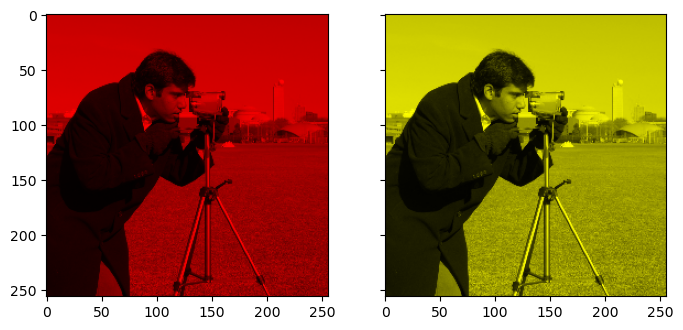

In [1]:
import matplotlib.pyplot as plt
from skimage import data
from skimage import color
from skimage import img_as_float, img_as_ubyte

grayscale_image = img_as_float(data.camera()[::2, ::2])
image = color.gray2rgb(grayscale_image)

red_multiplier = [1, 0, 0]
yellow_multiplier = [1, 1, 0]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4),
                               sharex=True, sharey=True)
ax1.imshow(red_multiplier * image)
ax2.imshow(yellow_multiplier * image)

plt.show()

In many cases, dealing with RGB values may not be ideal. Because of that,
there are many other `color spaces`_ in which you can represent a color
image. One popular color space is called HSV, which represents hue (~the
color), saturation (~colorfulness), and value (~brightness). For example, a
color (hue) might be green, but its saturation is how intense that green is
---where olive is on the low end and neon on the high end.

In some implementations, the hue in HSV goes from 0 to 360, since hues wrap
around in a circle. In scikit-image, however, hues are float values from 0
to 1, so that hue, saturation, and value all share the same scale.

    https://en.wikipedia.org/wiki/List_of_color_spaces_and_their_uses

Below, we plot a linear gradient in the hue, with the saturation and value
turned all the way up:



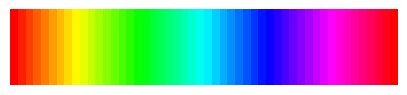

In [2]:
import numpy as np

hue_gradient = np.linspace(0, 1)
hsv = np.ones(shape=(1, len(hue_gradient), 3), dtype=float)
hsv[:, :, 0] = hue_gradient

all_hues = color.hsv2rgb(hsv)

fig, ax = plt.subplots(figsize=(5, 2))
# Set image extent so hues go from 0 to 1 and the image is a nice aspect ratio.
ax.imshow(all_hues, extent=(0 - 0.5 / len(hue_gradient),
                            1 + 0.5 / len(hue_gradient), 0, 0.2))
ax.set_axis_off()

Notice how the colors at the far left and far right are the same. That
reflects the fact that the hues wrap around like the color wheel (see HSV_
for more info).


Now, let's create a little utility function to take an RGB image and:

1. Transform the RGB image to HSV 2. Set the hue and saturation 3.
Transform the HSV image back to RGB



In [3]:
def colorize(image, hue, saturation=1):
    """ Add color of the given hue to an RGB image.

    By default, set the saturation to 1 so that the colors pop!
    """
    hsv = color.rgb2hsv(image)
    hsv[:, :, 1] = saturation
    hsv[:, :, 0] = hue
    return color.hsv2rgb(hsv)

Notice that we need to bump up the saturation; images with zero saturation
are grayscale, so we need to a non-zero value to actually see the color
we've set.

Using the function above, we plot six images with a linear gradient in the
hue and a non-zero saturation:



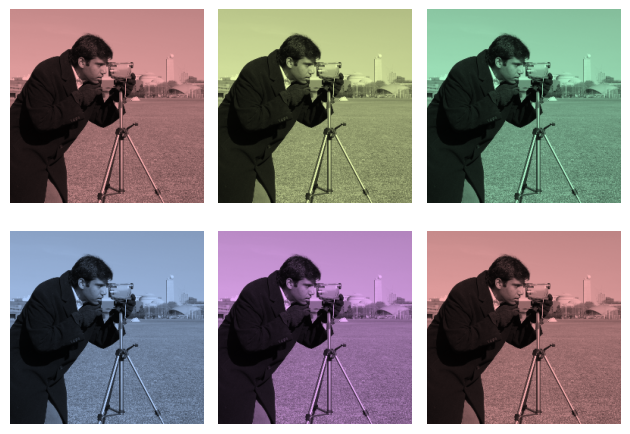

In [4]:
hue_rotations = np.linspace(0, 1, 6)

fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True)

for ax, hue in zip(axes.flat, hue_rotations):
    # Turn down the saturation to give it that vintage look.
    tinted_image = colorize(image, hue, saturation=0.3)
    ax.imshow(tinted_image, vmin=0, vmax=1)
    ax.set_axis_off()
fig.tight_layout()

You can combine this tinting effect with numpy slicing and fancy-indexing
to selectively tint your images. In the example below, we set the hue of
some rectangles using slicing and scale the RGB values of some pixels found
by thresholding. In practice, you might want to define a region for tinting
based on segmentation results or blob detection methods.



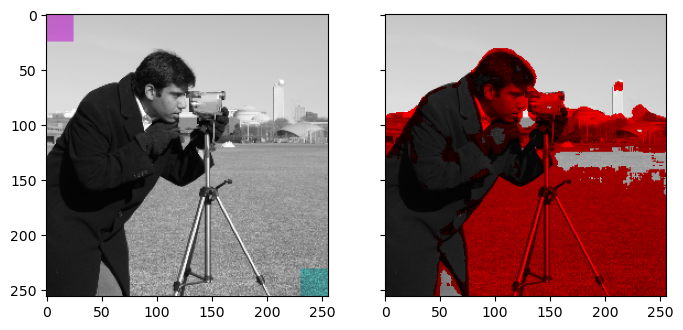

In [5]:
from skimage.filters import rank

# Square regions defined as slices over the first two dimensions.
top_left = (slice(25),) * 2
bottom_right = (slice(-25, None),) * 2

sliced_image = image.copy()
sliced_image[top_left] = colorize(image[top_left], 0.82, saturation=0.5)
sliced_image[bottom_right] = colorize(image[bottom_right], 0.5, saturation=0.5)

# Create a mask selecting regions with interesting texture.
noisy = rank.entropy(img_as_ubyte(grayscale_image), np.ones((9, 9)))
textured_regions = noisy > 4.25
# Note that using `colorize` here is a bit more difficult, since `rgb2hsv`
# expects an RGB image (height x width x channel), but fancy-indexing returns
# a set of RGB pixels (# pixels x channel).
masked_image = image.copy()
masked_image[textured_regions, :] *= red_multiplier

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4),
                               sharex=True, sharey=True)
ax1.imshow(sliced_image)
ax2.imshow(masked_image)

plt.show()

For coloring multiple regions, you may also be interested in
[skimage.color.label2rgb](http://scikit-
image.org/docs/0.9.x/api/skimage.color.html#label2rgb).

